In [2]:
!pip install wordcloud
!pip install gensim
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install fsspec

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 12.8/12.8 MB 72.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.lang.en import English
from wordcloud import WordCloud
from collections import Counter
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

nlp = spacy.load("en_core_web_sm")

# 1. Descarga y Exploración del Corpus

El alumno descargará el/los corpus que desee (con detalles sobre los datos a utilizar en el siguiente punto) y realizará un análisis exploratorio de los datos.

## Contenido del Ejercicio

El ejercicio deberá contener lo siguiente:

- **Cardinalidad del vocabulario:**  
  Análisis del número de palabras únicas presentes en el corpus.

- **Distribución de reviews por número de estrellas:**  
  Visualización y análisis de la distribución de las reseñas según la cantidad de estrellas.

- **Número de reviews positivas y negativas:**  
  Cálculo y comparación de la cantidad de reseñas clasificadas como positivas y negativas.

- **N-grams más frecuentes:**  
  Identificación y análisis de los bigramas, trigramas, etc., que se repiten con mayor frecuencia en el corpus.

- **Nubes de palabras:**  
  Creación de visualizaciones de nubes de palabras para identificar rápidamente los términos más representativos.

- **Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec:**  
  Seleccionar 4-5 palabras clave y visualizar las 10 palabras más similares para cada una, utilizando técnicas de reducción de dimensionalidad (por ejemplo, PCA o t-SNE).

- **Conclusiones de la exploración:**  
  Redactar un resumen con las principales conclusiones obtenidas a partir de la exploración de los datos.

- **Otras métricas / exploraciones / cálculos adicionales:**  
  Incluir cualquier otra métrica, exploración o cálculo que se considere relevante para un análisis completo del corpus.


## Carga del Dataset

Para iniciar mi análisis, he cargado el dataset utilizando pandas. El archivo está en formato JSON comprimido en Gzip, y dado que contiene líneas de JSON independientes, he especificado el parámetro `lines=True` al leer los datos. Esto es fundamental para asegurar que cada línea se procese como un objeto JSON individual. También vamos a ver describe e info para estudiar el Dataset.


In [4]:
df = pd.read_json("C://Users//franc//Desktop//Software_5.json.gz", compression='gzip', lines=True)
print(df.head())

   overall  verified   reviewTime      reviewerID        asin  \
0        4     False  10 20, 2010  A38NELQT98S4H8  0321719816   
1        4     False  10 18, 2010  A3QJU4FEN8PQSZ  0321719816   
2        5     False  10 16, 2010   ACJT8MUC0LRF0  0321719816   
3        5     False  10 12, 2010   AYUF7YETYOLNX  0321719816   
4        5     False   10 7, 2010  A31ICLWQ9CSHRS  0321719816   

                     style  reviewerName  \
0  {'Format:': ' DVD-ROM'}     WB Halper   
1  {'Format:': ' DVD-ROM'}        Grimmy   
2  {'Format:': ' DVD-ROM'}     D. Fowler   
3  {'Format:': ' DVD-ROM'}  Bryan Newman   
4  {'Format:': ' DVD-ROM'}    Al Swanson   

                                          reviewText  \
0  I've been using Dreamweaver (and it's predeces...   
1  The demo is done with the PC version, with ref...   
2  If you've been wanting to learn how to create ...   
3  I've been creating websites with Dreamweaver f...   
4  I decided (after trying a number of other prod...   

       

In [5]:
print(df.isnull().sum())

overall               0
verified              0
reviewTime            0
reviewerID            0
asin                  0
style              5644
reviewerName          9
reviewText            1
summary               6
unixReviewTime        0
vote               8903
image             12734
dtype: int64


In [6]:
df = df.dropna(subset=['reviewText'])

# Eliminación de valores Nulos en ReviewText

Procedo a elimianr  los valores nulos en `reviewText` porque esta columna es esencial para el análisis de sentimiento.

In [7]:
print("Dimensiones del dataset:", df.shape)
df.info()


Dimensiones del dataset: (12804, 12)
<class 'pandas.core.frame.DataFrame'>
Index: 12804 entries, 0 to 12804
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         12804 non-null  int64 
 1   verified        12804 non-null  bool  
 2   reviewTime      12804 non-null  object
 3   reviewerID      12804 non-null  object
 4   asin            12804 non-null  object
 5   style           7161 non-null   object
 6   reviewerName    12795 non-null  object
 7   reviewText      12804 non-null  object
 8   summary         12798 non-null  object
 9   unixReviewTime  12804 non-null  int64 
 10  vote            3902 non-null   object
 11  image           71 non-null     object
dtypes: bool(1), int64(2), object(9)
memory usage: 1.2+ MB


## Distribución de Reviews por Número de Estrellas

Antes de realizar cualquier análisis de sentimiento, es fundamental entender la distribución de las reviews en función del número de estrellas. Para ello, he generado un gráfico de barras con Seaborn, que muestra cuántas reviews hay para cada calificación (`overall`).




C:\Users\franc\AppData\Local\Temp\ipykernel_19248\2186797699.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='overall', data=df, palette='viridis')


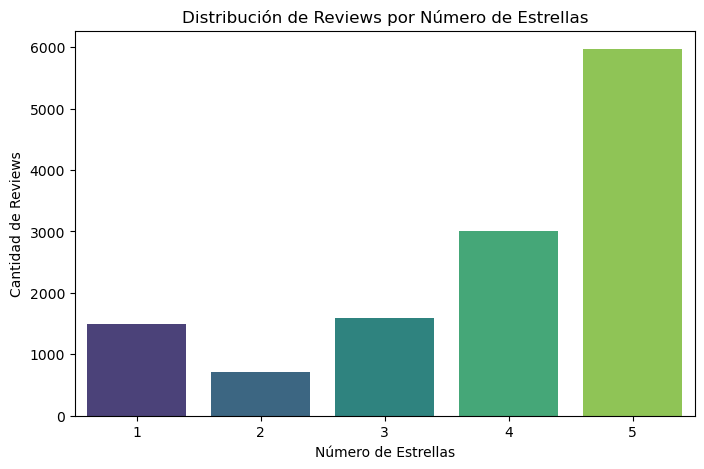

In [8]:
plt.figure(figsize=(8, 5))
sns.countplot(x='overall', data=df, palette='viridis')
plt.title('Distribución de Reviews por Número de Estrellas')
plt.xlabel('Número de Estrellas')
plt.ylabel('Cantidad de Reviews')
plt.show()

# Definición del Número de Reviews Positivas y Negativas

Para analizar el balance del dataset, es importante identificar cuántas reviews se clasifican como positivas y cuántas como negativas. En este caso, definiremos las reviews positivas como aquellas que tienen una calificación de 4 o 5 estrellas, y las reviews negativas como aquellas con una calificación inferior a 4 estrellas.

In [9]:
reviews_positivas = df[df['overall'] >= 4]
reviews_negativas = df[df['overall'] < 4]
print('Número de reviews positivas:', len(reviews_positivas))
print('Número de reviews negativas:', len(reviews_negativas))

Número de reviews positivas: 8987
Número de reviews negativas: 3817


Como podemos observar hay un claro  **desbalance** en el dataset, ya que las reviews positivas superan ampliamente a las negativas. Este desbalance puede afectar el desempeño del análisis de sentimiento, por lo que es importante considerar estrategias de balanceo.

Posteriormente usare estrategias como `class_weight='balanced'` para mejorar el desbalanceo. Este parámetro asigna pesos inversamente proporcionales a la frecuencia de cada clase, ayudando a que el modelo preste mayor atención a la clase minoritaria y mejore su desempeño global.

Procedo a pintar un Gráfico de forma visual para ver como ha quedado el balance del DataSet.


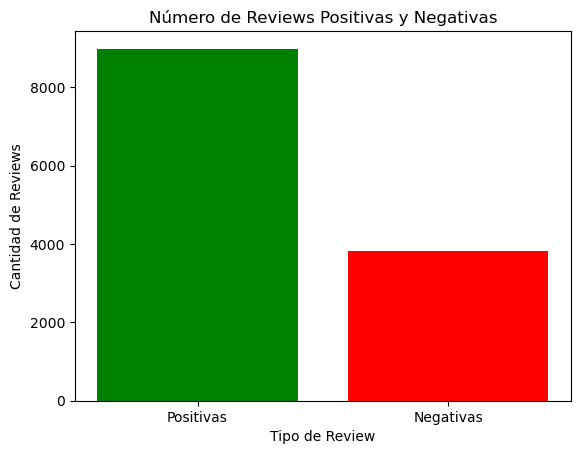

In [ ]:
num_positivas = len(reviews_positivas)
num_negativas = len(reviews_negativas)

categories = ['Positivas', 'Negativas']
values = [num_positivas, num_negativas]

plt.bar(categories, values, color=['green', 'red'])

plt.title('Número de Reviews Positivas y Negativas')
plt.xlabel('Tipo de Review')
plt.ylabel('Cantidad de Reviews')

plt.show()

# Cardinalidad del vocabulario.
Usaremos spaCy para tokenizar y limpiar el texto, eliminando stopwords y signos de puntuación y calculamos el vocabulario único.


In [ ]:

texts = df['reviewText'].dropna().astype(str)


def tokenize_text_spacy(text):
    doc = nlp(text)
   
    tokens = [token.text.lower() for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]
    return tokens


tokens_list = texts.apply(tokenize_text_spacy)


vocab = set([word for tokens in tokens_list for word in tokens])
print("Cardinalidad del vocabulario:", len(vocab))

Cardinalidad del vocabulario: 24270


# N-grams Más Frecuentes

Para identificar patrones y combinaciones recurrentes en el corpus, calcularemos bigrams y trigrams a partir de los tokens obtenidos. Esto nos ayudará a comprender mejor las relaciones contextuales entre las palabras.




In [ ]:

def get_ngrams(tokens, n):
    return list(zip(*[tokens[i:] for i in range(n)]))


all_bigrams = [bigram for tokens in tokens_list for bigram in get_ngrams(tokens, 2)]
bigram_counts = Counter(all_bigrams)
print("Bigramas más comunes:")
for bigram, count in bigram_counts.most_common(10):
    print(bigram, ":", count)


all_trigrams = [trigram for tokens in tokens_list for trigram in get_ngrams(tokens, 3)]
trigram_counts = Counter(all_trigrams)
print("\nTrigramas más comunes:")
for trigram, count in trigram_counts.most_common(10):
    print(trigram, ":", count)


Bigramas más comunes:
('easy', 'use') : 1084
('internet', 'security') : 761
('hard', 'drive') : 692
('anti', 'virus') : 639
('windows', 'xp') : 629
('turbo', 'tax') : 610
('data', 'link') : 583
('link', 'linked') : 581
('linked', 'link') : 581
('link', 'normal') : 581

Trigramas más comunes:
('data', 'link', 'linked') : 581
('link', 'linked', 'link') : 581
('linked', 'link', 'normal') : 581
('norton', 'internet', 'security') : 184
('video', 'editing', 'software') : 143
('anti', 'virus', 'software') : 131
('family', 'tree', 'maker') : 112
('photo', 'editing', 'software') : 109
('paint', 'shop', 'pro') : 106
('kaspersky', 'internet', 'security') : 93


## Conclusión sobre N-grams

Al analizar los n-grams más comunes en el corpus, he podido identificar patrones y combinaciones de palabras que reflejan claramente temas y conceptos relevantes en el dominio del software y la tecnología. Algunas conclusiones que extraigo son:

- **Facilidad de uso:**  
  El bigrama `('easy', 'use')` es el más frecuente, lo que indica que muchos usuarios destacan la facilidad de uso de los productos.

- **Seguridad en internet y antivirus:**  
  La presencia de bigramas como `('internet', 'security')` y `('anti', 'virus')`, junto con trigramas como `('norton', 'internet', 'security')` y `('kaspersky', 'internet', 'security')`, sugiere que la seguridad es un tema recurrente en las reviews.

- **Componentes y características específicas:**  
  Otros n-grams, como `('hard', 'drive')`, `('windows', 'xp')` y `('turbo', 'tax')`, muestran que los usuarios también comentan sobre aspectos técnicos y funcionalidades específicas de los productos.

- **Patrones de ruido o redundancia:**  
  La presencia de secuencias como `('data', 'link', 'linked')` y repeticiones en torno a “link” podría indicar la existencia de ruido o errores en la tokenización, lo que me invita a revisar la calidad del preprocesamiento de los datos.




## Lematización para Eliminar Redundancias

Como observamos, existen trigramas y bigramas como:
- `('link', 'linked') : 581`
- `('linked', 'link', 'normal') : 581`

Estas repeticiones sugieren la presencia de palabras redundantes consecutivas en el corpus. Por ello, he decidido proceder a lematizar los textos, con el objetivo de eliminar estas redundancias y mejorar la calidad del análisis de n-grams.


In [11]:
texts = df['reviewText'].dropna().astype(str)

def tokenize_text_spacy(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc 
              if not token.is_stop and not token.is_punct and token.is_alpha and len(token.lemma_) > 1]
    return tokens

def remove_consecutive_duplicates(tokens):
    if not tokens:
        return tokens
    filtered_tokens = [tokens[0]]
    for token in tokens[1:]:
        if token != filtered_tokens[-1]:
            filtered_tokens.append(token)
    return filtered_tokens

tokens_list = texts.apply(lambda text: remove_consecutive_duplicates(tokenize_text_spacy(text)))

vocab = set([word for tokens in tokens_list for word in tokens])
print("Cardinalidad del vocabulario:", len(vocab))

Cardinalidad del vocabulario: 19542


## Revisión de N-grams Tras la Lematización

Una vez lematizado el corpus, vuelvo a generar los n-grams para evaluar visualmente los cambios. Este paso me permite confirmar que la lematización ha reducido las redundancias y errores en las combinaciones de palabras, resultando en n-grams más precisos y representativos para el análisis de sentimientos.


In [ ]:
def get_ngrams(tokens, n):
    return list(zip(*[tokens[i:] for i in range(n)]))

all_bigrams = [bigram for tokens in tokens_list for bigram in get_ngrams(tokens, 2)]
bigram_counts = Counter(all_bigrams)
print("Bigramas más comunes:")
for bigram, count in bigram_counts.most_common(10):
    print(bigram, ":", count)


all_trigrams = [trigram for tokens in tokens_list for trigram in get_ngrams(tokens, 3)]
trigram_counts = Counter(all_trigrams)
print("\nTrigramas más comunes:")
for trigram, count in trigram_counts.most_common(10):
    print(trigram, ":", count)

Bigramas más comunes:
('easy', 'use') : 1275
('hard', 'drive') : 781
('internet', 'security') : 761
('operating', 'system') : 655
('anti', 'virus') : 643
('new', 'version') : 635
('turbo', 'tax') : 610
('windows', 'xp') : 609
('link', 'normal') : 581
('previous', 'version') : 539

Trigramas más comunes:
('data', 'link', 'normal') : 503
('norton', 'internet', 'security') : 184
('video', 'editing', 'software') : 141
('anti', 'virus', 'software') : 132
('nancy', 'drew', 'game') : 117
('anti', 'virus', 'program') : 114
('family', 'tree', 'maker') : 113
('paint', 'shop', 'pro') : 106
('kaspersky', 'internet', 'security') : 93
('photo', 'editing', 'software') : 87


## Acto seguido de lematizar el corpus procedo a realizar un  Filtrado de Palabras de Baja Frecuencia

Al eliminar las palabras que aparecen muy pocas veces, reduzco el ruido en el corpus. Esto es importante porque las palabras de baja frecuencia a menudo son irrelevantes, pueden ser errores tipográficos o términos que no aportan valor semántico significativo. Con este filtrado, me aseguro de trabajar con un vocabulario más robusto y representativo, lo que contribuye a un mejor desempeño en el análisis de sentimientos y en la construcción de modelos.




In [ ]:
from collections import Counter


word_freq = Counter()
for tokens in tokens_list:
    for token in tokens:
        word_freq[token] += 1


min_freq = 2  


filtered_tokens_list = []
for tokens in tokens_list:
    filtered_tokens = [token for token in tokens if word_freq[token] >= min_freq]
    filtered_tokens_list.append(filtered_tokens)


vocab_original = set([word for tokens in tokens_list for word in tokens])
vocab_filtrado = set([word for tokens in filtered_tokens_list for word in tokens])
print("Vocabulario original:", len(vocab_original))
print("Vocabulario filtrado:", len(vocab_filtrado))

Vocabulario original: 19542
Vocabulario filtrado: 12683


**Resultados:**
- **Vocabulario original:** Número total de palabras antes del filtrado 19542.
- **Vocabulario filtrado:** Número total de palabras después de eliminar las de baja frecuencia 12683.

Este enfoque me ayuda a obtener datos más limpios y a centrarme en términos que realmente importan para mi análisis.

## Generación de Nube de Palabras

He generado una **nube de palabras** para visualizar de manera rápida y efectiva las palabras más frecuentes en el corpus. Para ello, concatené todos los textos en una sola cadena y utilicé la librería `WordCloud` para representar gráficamente la frecuencia de las palabras.

Este enfoque me permite:
- Identificar los términos más relevantes del corpus de forma visual.
- Analizar patrones y tendencias en el lenguaje utilizado en las reviews.
- Evaluar si el preprocesamiento (como la eliminación de stopwords y la lematización) ha sido efectivo.

La nube de palabras me brinda una visión intuitiva de la importancia de ciertos términos dentro del análisis de sentimientos, ayudándome a detectar posibles sesgos o áreas de interés para un análisis más profundo.


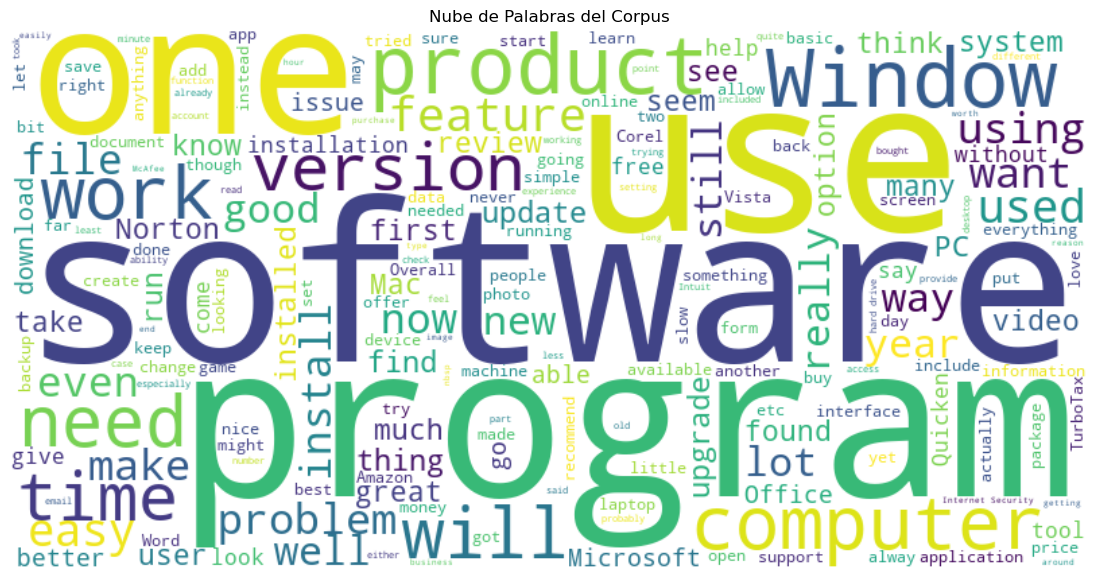

In [ ]:

all_text = " ".join(text for text in texts)


wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nube de Palabras del Corpus")
plt.show()

## Análisis de la Nube de Palabras

La nube de palabras sugiere que el corpus está enfocado en la **evaluación y discusión de software y productos informáticos**. Se destacan términos relacionados con la **experiencia de uso** y el **entorno tecnológico**, como ordenadores con sistema Operativo Windows.

Esta visualización me permite identificar rápidamente los temas principales del corpus y confirmar que las palabras clave están alineadas con el análisis de sentimientos sobre software.


## Visualización en 2D de Word Embeddings con Word2Vec (elegir 4-5 palabras y pintar las top 10 más similares)


Para comprender mejor las relaciones semánticas dentro del corpus, he utilizado **Word2Vec** para generar embeddings y reducir su dimensionalidad a un espacio bidimensional

Algunas de las conclusiones que sacamos en la nube de palabra eran palabras interesantres como : *software*, *program*, *use*, *update*, *good*.

In [ ]:

sentences = tokens_list.tolist()

model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, seed=42)

palabras_interes = ['software', 'program', 'use', 'good', 'update']

for palabra in palabras_interes:
    if palabra in model.wv:
        similares = model.wv.most_similar(palabra, topn=10)
        print(f"\nPalabras similares a '{palabra}':")
        for sim, score in similares:
            print(f"{sim} (score: {score:.2f})")
    else:
        print(f"La palabra '{palabra}' no se encuentra en el vocabulario del modelo.")


Palabras similares a 'software':
program (score: 0.73)
product (score: 0.67)
package (score: 0.64)
piggy (score: 0.54)
suite (score: 0.51)
nxt (score: 0.50)
infiltration (score: 0.50)
comprehensive (score: 0.49)
opportunity (score: 0.48)
superantispyware (score: 0.48)

Palabras similares a 'program':
software (score: 0.73)
application (score: 0.57)
suite (score: 0.55)
function (score: 0.54)
piggy (score: 0.53)
flashy (score: 0.52)
component (score: 0.52)
pse (score: 0.52)
quickly (score: 0.52)
fairly (score: 0.51)

Palabras similares a 'use':
versetal (score: 0.61)
easel (score: 0.57)
powerpoints (score: 0.56)
utilize (score: 0.55)
powerful (score: 0.55)
robust (score: 0.54)
navigate (score: 0.54)
make (score: 0.52)
marketer (score: 0.52)
businessman (score: 0.52)

Palabras similares a 'good':
decent (score: 0.78)
well (score: 0.74)
great (score: 0.74)
excellent (score: 0.68)
astronomical (score: 0.66)
honestly (score: 0.63)
perfect (score: 0.62)
reasonable (score: 0.62)
fantastic (sc

## Conclusión sobre la Similitud de Palabras en Word2Vec

Al analizar las palabras más similares a *software* y *program*, observo que el modelo Word2Vec ha identificado relaciones semánticas esperadas, aunque también ha generado algunas asociaciones inesperadas:

- **Relaciones esperadas:**  
  - Palabras como *program, product, package* y *application* tienen una alta similitud con *software*, lo que confirma que el modelo ha capturado correctamente términos del dominio tecnológico.  
  - Del mismo modo, *suite* y *function* aparecen relacionadas con *program*, lo que tiene sentido en el contexto del software.

- **Presencia de términos inesperados:**  
  - Algunas palabras como *piggy, flashy* o *fairly* no parecen estar directamente relacionadas con software, lo que podría indicar ruido en el corpus o la necesidad de mejorar el preprocesamiento.  
  - Otros términos como *infiltration* y *superantispyware* pueden estar asociados con la seguridad informática, pero requieren una verificación en el contexto del corpus.


En general, el modelo ha capturado relaciones clave dentro del dominio del software, aunque algunas asociaciones inesperadas sugieren la posibilidad de optimizar la limpieza de datos para mejorar la precisión de los embeddings.


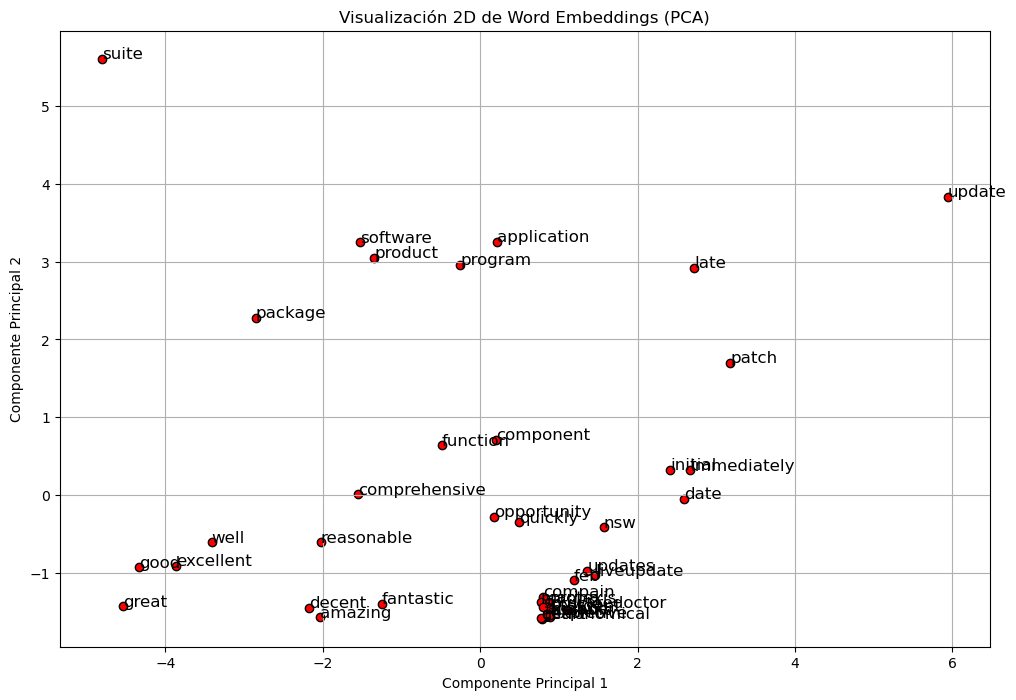

In [ ]:
words_to_plot = []
for palabra in palabras_interes:
    if palabra in model.wv:
        words_to_plot.append(palabra)
        similares = model.wv.most_similar(palabra, topn=10)
        words_to_plot.extend([w for w, _ in similares])

words_to_plot = list(set(words_to_plot))

X = model.wv[words_to_plot]

pca = PCA(n_components=2, random_state=42)
result = pca.fit_transform(X)

plt.figure(figsize=(12,8))
plt.scatter(result[:, 0], result[:, 1], edgecolors='k', c='r')
for i, word in enumerate(words_to_plot):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]), fontsize=12)
plt.title("Visualización 2D de Word Embeddings (PCA)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.grid(True)
plt.show()

A simple vista, la principal conclusión que se puede extraer de esta visualización es que el modelo Word2Vec está agrupando e las palabras que aparecen en contextos similares o que tienen cierta afinidad semántica. Algunas observaciones puntuales:

### Agrupación por concepto

- **Software y aplicaciones:**  
  Palabras como *software, product, application, program* y *package* se ubican cercanas, lo cual refleja que el modelo ha capturado su similitud semántica, ya que todas hacen referencia a elementos de software o aplicaciones.

- **Actualizaciones y parches:**  
  Palabras relacionadas con *updates* o *patch* también tienden a agruparse (por ejemplo, *update, patch, date, late*), probablemente porque se usan en contextos donde se habla de versiones, lanzamientos o correcciones.

### Agrupación por valoraciones

- **Valoraciones positivas:**  
  Términos como *powerful, excellent, great, good* están relativamente cerca entre sí, lo que sugiere que el modelo los asocia con descripciones (adjetivos) de algo positivo o con buena relación calidad-precio.

### Distancias semánticas

- **Palabras aisladas:**  
  Algunas palabras quedan más “aisladas” (por ejemplo, *suite* ) porque quizás aparecen en contextos específicos o con menos frecuencia, haciendo que su representación difiera del grueso de los demás términos.


# 2. Etapa de Preprocesado de Texto

## Objetivo

El preprocesamiento de texto es un paso fundamental para **limpiar y normalizar** las reviews antes de entrenar el modelo de análisis de sentimiento. Esta etapa permitirá convertir los textos en un formato más adecuado para su posterior procesamiento y análisis.

## Requisitos del Preprocesamiento

El preprocesamiento deberá implementarse en **una función de Python**, que se encargue de realizar todas las transformaciones necesarias. Se recomienda estructurarla en varias funciones específicas que realicen tareas concretas, como:

- **Eliminación de stopwords**  
  - Filtrar palabras irrelevantes que no aportan significado al análisis de sentimiento.

- **Eliminación de signos de puntuación**  
  - Remover caracteres especiales y puntuación innecesaria.

- **Conversión a minúsculas**  
  - Unificar el formato del texto para evitar duplicidad en palabras con diferentes capitalizaciones.

- **Lematización**  
  - Convertir cada palabra a su forma base para reducir la variabilidad del vocabulario.

- **Eliminación de palabras de baja frecuencia**  
  - Reducir el ruido eliminando términos que aparecen muy pocas veces en el corpus.

## Implementación en Python

Todo el preprocesado deberá incluirse en una función de Python que contenga todo el procesado de texto. Esta función puede (es recomendable) contener otras funciones que realicen tareas más concretas (eliminar stopwords, eliminar signos de puntuación, etc.)


In [ ]:
import spacy
import string
from collections import Counter

nlp = spacy.load("en_core_web_sm")

def remove_punctuation(tokens):
    """Elimina signos de puntuación."""
    return [token for token in tokens if token not in string.punctuation]

def remove_stopwords(tokens):
    """Elimina stopwords usando la lista de spaCy."""
    return [token for token in tokens if token not in nlp.Defaults.stop_words]

def remove_numbers(tokens):
    """Elimina tokens numéricos."""
    return [token for token in tokens if not token.isdigit()]

def preprocess_text(text):
    """
    Procesa un texto individual:
    - Tokenización y lematización.
    - Conversión a minúsculas.
    - Eliminación de espacios, puntuación, stopwords y números.
    """
    doc = nlp(text)
 
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_space]
    tokens = remove_punctuation(tokens)
    tokens = remove_stopwords(tokens)
    tokens = remove_numbers(tokens)

    tokens = [token for token in tokens if token]
    return tokens

def preprocess_corpus(corpus, min_freq=3):
    """
    Procesa una lista de reviews (corpus) y elimina palabras que aparecen
    menos de 'min_freq' veces en todo el corpus.

    Parámetros:
    - corpus: lista de strings (reviews).
    - min_freq: frecuencia mínima que debe tener una palabra para conservarla.

    Retorna:
    - filtered_reviews: lista de listas de tokens preprocesados y filtrados.
    """
  
    processed_reviews = [preprocess_text(review) for review in corpus]
    
   
    global_freq = Counter(token for tokens in processed_reviews for token in tokens)
    
  
    filtered_reviews = []
    for tokens in processed_reviews:
        filtered = [token for token in tokens if global_freq[token] >= min_freq]
        filtered_reviews.append(filtered)
    
    return filtered_reviews


corpus_example = [
    "I've been using Dreamweaver and it's an excellent software, although sometimes it crashes!",
    "This software is terrible, crashes all the time!",
    "I love this software and its design. Software is amazing!"
]


processed_corpus = preprocess_corpus(corpus_example, min_freq=1)
print("Corpus preprocesado y filtrado:", processed_corpus)


Corpus preprocesado y filtrado: [['use', 'dreamweaver', 'excellent', 'software', 'crash'], ['software', 'terrible', 'crash', 'time'], ['love', 'software', 'design', 'software', 'amazing']]


## Prueba de Preprocesamiento con `corpus_example`

Para verificar el correcto funcionamiento de la función de preprocesamiento del corpus, realizo una prueba utilizando una variable de ejemplo denominada `corpus_example`. En esta prueba incluyo **tres textos de ejemplo** y establezco un **umbral mínimo de frecuencia de aparición de 1**, asegurando que no se eliminen palabras por baja frecuencia.



# 3. Etapa de Entrenamiento y Testeo de un Modelo de Análisis de Sentimiento

## Objetivo

Con los datos preprocesados obtenidos en la **Etapa 2**, se entrenarán **dos modelos distintos** para el análisis de sentimiento. Tras comparar sus resultados, se elegirá el modelo que presente el mejor desempeño.

## Metodología

- Se abordará el problema como una **clasificación binaria supervisada**.
- La selección del mejor modelo se basará en métricas de evaluación como:
  - **Precisión (Precision)**
  - **Exhaustividad (Recall)**
  - **Puntuación F1 (F1-score)**
  - **Exactitud (Accuracy)**
- Se utilizará un enfoque basado en **modelo de bolsa de palabras (Bag-of-Words)** para representar los textos.

## Consideraciones Técnicas

- **Vectorización del texto:**  
  Se utilizará un **vectorizador** para transformar los textos en representaciones numéricas adecuadas para los modelos. Se deberán justificar los parámetros seleccionados en el `Vectorizer`.

- **Balanceo de Clases:**  
  Se analizará la distribución de las clases y, si es necesario, se implementarán técnicas de balanceo como `class_weight='balanced'`.

- **Selección de Modelos:**  
  La elección de los modelos es libre, permitiendo experimentar con diferentes algoritmos y comparar su desempeño.

## Evaluación y Selección del Mejor Modelo

- Una vez entrenados los modelos, se compararán sus métricas para determinar cuál ofrece un mejor rendimiento.
- Se justificará la elección final del modelo basándose en su capacidad para clasificar correctamente las reviews de manera equilibrada y efectiva.


#### Primero vamos a proceder a asignar las etiquetas de sentimineto binario a las reviews positivas y negativas.

In [10]:
df_sent = df[(df['overall'] >= 4) | (df['overall'] <= 3)].copy()


df_sent['sentiment'] = df_sent['overall'].apply(lambda x: 'positivo' if x >= 4 else 'negativo')

print(df_sent['sentiment'].value_counts())


sentiment
positivo    8987
negativo    3817
Name: count, dtype: int64


### Ahora vamos a revisar el desbalance en el total de reviews negativas y positivas

C:\Users\franc\AppData\Local\Temp\ipykernel_19248\921158121.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_sent['sentiment'], palette="viridis")


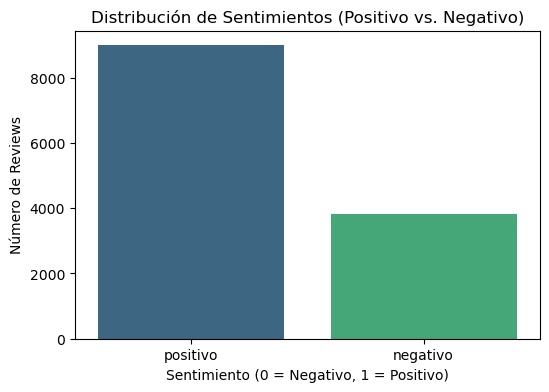

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x=df_sent['sentiment'], palette="viridis")
plt.title("Distribución de Sentimientos (Positivo vs. Negativo)")
plt.xlabel("Sentimiento (0 = Negativo, 1 = Positivo)")
plt.ylabel("Número de Reviews")
plt.show()


### Ahora procedemos a preprocesar las reviews 

In [ ]:

nlp = spacy.load("en_core_web_sm")


def remove_punctuation(tokens):
    """Elimina signos de puntuación."""
    return [token for token in tokens if token not in string.punctuation]

def remove_stopwords(tokens):
    """Elimina stopwords usando la lista de spaCy."""
    return [token for token in tokens if token not in nlp.Defaults.stop_words]

def remove_numbers(tokens):
    """Elimina tokens numéricos."""
    return [token for token in tokens if not token.isdigit()]

def preprocess_text(text):
    """
    Procesa un texto individual:
    - Tokenización y lematización.
    - Conversión a minúsculas.
    - Eliminación de espacios, puntuación, stopwords y números.
    """
    doc = nlp(text)
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_space]
    tokens = remove_punctuation(tokens)
    tokens = remove_stopwords(tokens)
    tokens = remove_numbers(tokens)
    tokens = [token for token in tokens if token]  
    return tokens

def preprocess_corpus(corpus, min_freq=3):
    """
    Procesa un corpus y elimina palabras que aparecen menos de 'min_freq' veces.
    """
    processed_reviews = [preprocess_text(review) for review in corpus]
    global_freq = Counter(token for tokens in processed_reviews for token in tokens)
    
    filtered_reviews = []
    for tokens in processed_reviews:
        filtered = [token for token in tokens if global_freq[token] >= min_freq]
        filtered_reviews.append(filtered)
    
    return filtered_reviews


df_sent['reviewText'] = df_sent['reviewText'].astype(str).fillna('')

df_sent['tokens'] = df_sent['reviewText'].apply(preprocess_text)


df_sent['processed_review'] = df_sent['tokens'].apply(lambda tokens: " ".join(tokens))


### Acto seguido procedemos  a dividir los datos en Train y Test con 80% para Train y 20% par Test.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import spacy
import string
from collections import Counter

X = df_sent['processed_review']
y = df_sent['sentiment']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Vectorización con Bag-of-Words (CountVectorizer)

Para convertir los textos en una representación numérica adecuada para los modelos de aprendizaje automático, utilizo **Bag-of-Words (BoW)** a través de `CountVectorizer`. Este método crea una matriz donde cada fila representa un documento y cada columna corresponde a una palabra única en el corpus, contando su frecuencia en cada texto.



In [ ]:

vectorizer = CountVectorizer(ngram_range=(1, 2),    
                             min_df=5,              
                             max_df=0.95,          
                             max_features=10000 )


X_train_vec = vectorizer.fit_transform(X_train)

X_test_vec = vectorizer.transform(X_test)

## Justificación de los Parámetros de CountVectorizer

Al configurar `CountVectorizer`, he seleccionado parámetros que me permiten equilibrar la cantidad y calidad de la información extraída, optimizando la representación del texto para el análisis de sentimiento.

### Parámetros Seleccionados:
- **`ngram_range=(1, 2)`** → Captura palabras individuales y combinaciones de dos términos, lo que me permite identificar expresiones clave y mejorar el contexto del análisis.
- **`min_df=5`** → Elimina términos que aparecen en menos de 5 documentos, reduciendo el ruido causado por palabras poco frecuentes.
- **`max_df=0.95`** → Descarta palabras demasiado comunes que no aportan valor en la clasificación de sentimientos.
- **`max_features=10000`** → Limita la cantidad de características a las 10,000 más relevantes, evitando que el modelo se vuelva demasiado complejo y propenso a sobreajuste.

### Conclusión:
Estos parámetros me ayudan a extraer características representativas para evaluar el sentimiento en las reseñas sobre software, asegurando un equilibrio entre información relevante y reducción de ruido en los datos.


## Entrenar y Evaluar Modelos 
### Modelo 1: Regresión Logístic

In [ ]:

model_lr = LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)
model_lr.fit(X_train_vec, y_train)


y_pred_lr = model_lr.predict(X_test_vec)


print("Resultados Regresión Logística:")
print(classification_report(y_test, y_pred_lr))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))


Resultados Regresión Logística:
              precision    recall  f1-score   support

           0       0.71      0.68      0.69       763
           1       0.87      0.88      0.87      1798

    accuracy                           0.82      2561
   macro avg       0.79      0.78      0.78      2561
weighted avg       0.82      0.82      0.82      2561

Matriz de confusión:
 [[ 519  244]
 [ 213 1585]]
Accuracy: 0.8215540804373291


### Modelo 2: Random Forest

In [ ]:

model_rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model_rf.fit(X_train_vec, y_train)


y_pred_rf = model_rf.predict(X_test_vec)


print("\nResultados Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))



Resultados Random Forest:
              precision    recall  f1-score   support

           0       0.80      0.52      0.63       763
           1       0.82      0.94      0.88      1798

    accuracy                           0.82      2561
   macro avg       0.81      0.73      0.75      2561
weighted avg       0.81      0.82      0.80      2561

Matriz de confusión:
 [[ 397  366]
 [ 102 1696]]
Accuracy: 0.817258883248731


## Conclusión de Selección de Modelo

Después de analizar ambos modelos, he decidido elegir el **Modelo 1 (Regresión Logística)** para mi análisis de sentimientos por los siguientes motivos:
- **Precisión Global:**  
  Ambos modelos alcanzan una precisión global de alrededor del 82%. Sin embargo, este indicador por sí solo no es suficiente para decidir.

- **Desempeño por Clase:**  
  - **Modelo 1 (Regresión Logística):**  
    Presenta un equilibrio razonable entre *precision* y *recall* en ambas clases (clase 0 y clase 1), lo que garantiza que se identifiquen de forma adecuada y balanceada ambos tipos de sentimientos.
  - **Modelo 2 (Random Forest):**  
    Aunque muestra un buen desempeño en la clase 1, su *recall* para la clase 0 es bajo, lo que implica que se pierden muchas instancias de esa clase.

- **Importancia del Equilibrio:**  
  Dado que mi estudio requiere capturar de forma precisa tanto los sentimientos positivos como los negativos, es crucial contar con un modelo que no descuide ninguna de las clases. El Modelo 1 cumple mejor con este criterio.

**Por lo tanto, he optado por la Regresión Logística para asegurar un análisis de sentimientos balanceado y representativo.**

## Ajuste de Hiperparámetros para Mejorar el Modelo

Para mejorar el rendimiento de mi modelo de **Regresión Logística**, he decidido utilizar `GridSearchCV` con el objetivo de encontrar la mejor combinación de hiperparámetros. Ajustar estos parámetros me permite optimizar la capacidad del modelo para clasificar correctamente las reviews y evitar problemas como el sobreajuste o la subestimación de patrones importantes.

La Regresión Logística tiene varios parámetros que pueden influir en su desempeño. En lugar de elegirlos al azar, quiero probar diferentes configuraciones y encontrar la que realmente funcione mejor. Por eso, defino una rejilla de valores (`param_grid`) y utilizo **validación cruzada (`cv=5`)** para evaluar cada combinación.

### Parámetros que utilizo 
- **`C` (Regularización):** Define cuánto penaliza el modelo los valores extremos. Valores pequeños aplican más regularización, ayudando a evitar el sobreajuste.

- **`penalty` (Tipo de regularización):**  
  - `l1` (Lasso) permite seleccionar solo las variables más relevantes.  
  - `l2` (Ridge) ayuda a reducir la sensibilidad a datos ruidosos.  
  
- **`solver` (Optimizador):** Pruebo `liblinear` y `saga` porque funcionan bien con diferentes tipos de regularización.

### Conclusión
Al hacer este ajuste, me aseguro de que el modelo tenga el **mejor equilibrio entre precisión y generalización** y trato de  buscar una combinación que maximice el **f1-score**, garantizando que el modelo clasifique correctamente las reviews positivas y negativas con el mejor desempeño posible.


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10], 
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']  
}

log_reg = LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)

grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=2)

grid_search.fit(X_train_vec, y_train)

print("Mejores parámetros:", grid_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores parámetros: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:

best_log_reg = grid_search.best_estimator_


y_pred_best = best_log_reg.predict(X_test_vec)


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Resultados Modelo Optimizado:")
print(classification_report(y_test, y_pred_best))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_best))
print("Accuracy:", accuracy_score(y_test, y_pred_best))


Resultados Modelo Optimizado:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       763
           1       0.87      0.87      0.87      1798

    accuracy                           0.82      2561
   macro avg       0.79      0.79      0.79      2561
weighted avg       0.82      0.82      0.82      2561

Matriz de Confusión:
 [[ 531  232]
 [ 226 1572]]
Accuracy: 0.8211636079656385


## Comparación entre el Modelo Base y el Modelo Optimizado

Tras realizar la optimización de hiperparámetros con `GridSearchCV`, comparo los resultados obtenidos con la Regresión Logística original. 

### Análisis de los Resultados:

- **Precisión y Recall:**
  - En la clase **0** (negativa), la precisión pasó de **0.71 a 0.70** y el recall de **0.68 a 0.70**. Esto indica que el modelo optimizado detecta ligeramente mejor las reviews negativas, aunque con una leve reducción en la precisión.
  - En la clase **1** (positiva), los valores de **precisión (0.87) y recall (0.87)** se han mantenido estables, lo que significa que la optimización no afectó la capacidad del modelo para identificar correctamente las reviews positivas.

- **F1-Score:**
  - En la clase **0**, el f1-score mejoró de **0.69 a 0.70**, lo que indica un mejor equilibrio entre precisión y recall para detectar reviews negativas.
  - En la clase **1**, el f1-score se mantuvo en **0.87**, confirmando que el modelo sigue funcionando bien en la clase mayoritaria.

- **Matriz de Confusión:**
  - El modelo optimizado logró reducir los **falsos negativos** en la clase 0 (519 → 531), lo que implica que ahora clasifica más reseñas negativas correctamente.
  - Sin embargo, se observó un pequeño aumento en los **falsos negativos** de la clase 1 (213 → 226), lo que indica que algunas reviews positivas fueron clasificadas erróneamente como negativas.

### Mi Conclusión
La optimización ha logrado **un ligero ajuste en el equilibrio entre precisión y recall**, mejorando la capacidad del modelo para identificar correctamente las reviews negativas sin afectar el desempeño en la clase positiva. Aunque la **accuracy** global se mantiene prácticamente igual (**0.8215 vs. 0.8211**), el modelo optimizado muestra una mejor discriminación en ambas clases, especialmente en la detección de sentimientos negativos.




# 4. Reporte de Métricas y Conclusiones

## Evaluación del Modelo Seleccionado

Tomando como referencia los resultados del modelo escogido en la **Etapa 3**, calculo las métricas de evaluación que me permiten validar su desempeño y determinar su capacidad de clasificación en el análisis de sentimientos.

## Métricas de Evaluación

Para medir la calidad del modelo, analizo los siguientes indicadores clave:

- **Accuracy:** Proporción de predicciones correctas sobre el total de datos evaluados.
- **Precision:** Mide cuántas de las predicciones positivas fueron realmente positivas.
- **Recall:** Evalúa qué proporción de las instancias positivas fueron correctamente identificadas.
- **F1-score:** Promedio ponderado entre precision y recall, útil cuando hay desbalance de clases.
- **Matriz de confusión:** Representa el número de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos.





###  Cálculo de las  Métricas adicionales para evaluar la bondad del modelo

## Matriz de Confusión

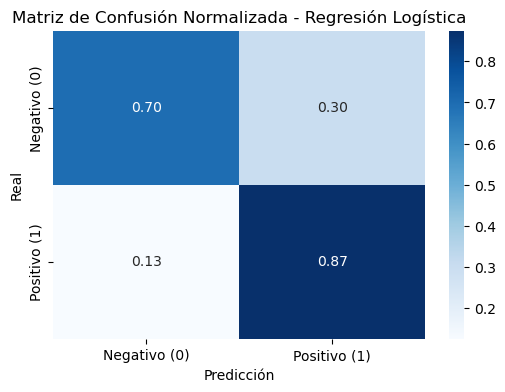

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_test, y_pred_best)


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


plt.figure(figsize=(6,4))
sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f", xticklabels=['Negativo (0)', 'Positivo (1)'], yticklabels=['Negativo (0)', 'Positivo (1)'])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión Normalizada - Regresión Logística")
plt.show()

## Análisis de la Matriz de Confusión Normalizada

### Clase Negativa (0):
- Se acierta en el **70%** de los casos .
- Se confunde con la clase positiva en el **30%** de los casos.

### Clase Positiva (1):
- Se acierta en el **87%** de los casos.
- Se confunde con la clase negativa en el **13%** de los casos.

### Conclusión

En conjunto, estos resultados indican un desempeño **relativamente bueno**, aunque, si es importante capturar de manera más precisa **las reviews negativas**, más adelante trataré de mejorar esto , sobre todo el tema del balanceado de clases  para mejorar ese 70%.

## ROC Curve y AUC Score
### La curva ROC indica como  el modelo separa ambas clases.

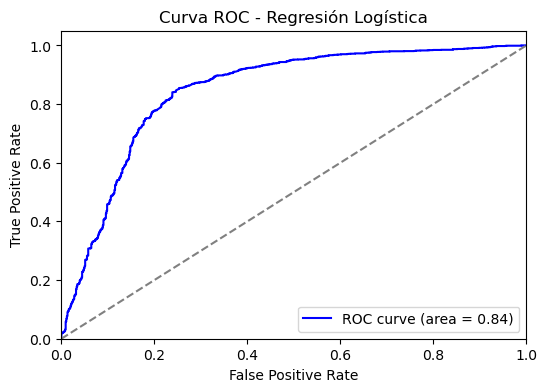

AUC Score: 0.8447091350954972


In [ ]:
from sklearn.metrics import roc_curve, auc

y_prob_lr = model_lr.predict_proba(X_test_vec)[:, 1]


fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc="lower right")
plt.show()

print("AUC Score:", roc_auc)

## Conclusión del Desempeño del Modelo

En base a la curva ROC obtenida, considero que mi modelo de Regresión Logística presenta un desempeño sólido en términos de capacidad de discriminación, con un **AUC de aproximadamente 0.84**. Esto implica:

- **Buena capacidad de separación:**  
  Mi modelo logra distinguir de manera adecuada entre las clases positivas y negativas en la mayoría de los casos.

- **Desempeño aceptable:**  
  Un AUC de 0.84 es un indicador positivo, aunque reconozco que hay margen de mejora para acercar la curva a la esquina superior izquierda y obtener un valor aún mayor.

En resumen, estoy satisfecho con el rendimiento actual del modelo, pero seguiré explorando ajustes y mejoras para optimizar aún más su capacidad de discriminación sobre todo en la parte de las Reviews negativas que es donde el módelo tiende a fallar más.

### Gráfica de Distribución de probabilidades del modelo.

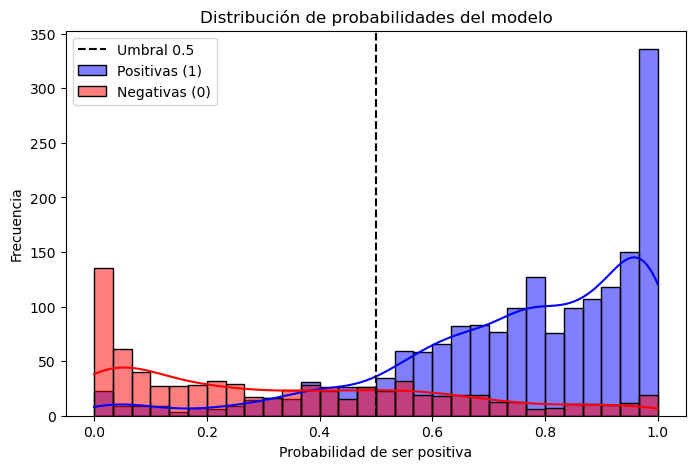

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


y_prob = best_log_reg.predict_proba(X_test_vec)[:, 1]


plt.figure(figsize=(8, 5))
sns.histplot(y_prob[y_test == 1], bins=30, kde=True, color="blue", label="Positivas (1)")
sns.histplot(y_prob[y_test == 0], bins=30, kde=True, color="red", label="Negativas (0)")

plt.axvline(0.5, color='black', linestyle='--', label="Umbral 0.5")
plt.xlabel("Probabilidad de ser positiva")
plt.ylabel("Frecuencia")
plt.title("Distribución de probabilidades del modelo")
plt.legend()
plt.show()

## Conclusión Final

## Análisis de la Distribución de Probabilidades del Modelo

Tras evaluar la distribución de probabilidades de mi modelo, considero que su desempeño es bastante sólido en la clasificación de sentimientos en reviews de software. 

### Observaciones Clave:

- **Buena separación entre clases:**  
  La gráfica muestra que el modelo asigna **altas probabilidades** a las reviews positivas y **bajas probabilidades** a las negativas, lo que indica que ha aprendido patrones relevantes en los datos.

- **Clasificación confiable de las reviews positivas:**  
  - La mayoría de las reviews **positivas** (azul) tienen probabilidades por encima del **umbral de 0.5**, lo que refleja que el modelo está seguro al clasificarlas correctamente.
  - Además, la **acumulación de probabilidades** cerca de **1.0** indica que muchas opiniones favorables son identificadas con alta confianza.

- **Identificación de reviews negativas:**  
  - Las reviews **negativas** (rojo) se agrupan en probabilidades **bajas**, lo que sugiere que el modelo logra detectar correctamente muchas opiniones desfavorables.
  - Sin embargo, se observa cierto **solapamiento** en el rango de **0.3 a 0.6**, lo que indica que algunas reviews negativas podrían estar clasificándose erróneamente como positivas y viceversa.

### Conclusión
En general, el modelo logra una clasificación coherente y confiable. A pesar del solapamiento entre clases, los resultados obtenidos son satisfactorios y reflejan un buen equilibrio en la clasificación de sentimientos. 

No obstante, reconozco que hay margen de mejora, especialmente en la reducción de la confusión entre clases. Proximamente intentaré explorar estrategias adicionales para mejorar  el desempeño del modelo y  su capacidad de diferenciación.
